In [3]:
data_dir='/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_1/'
num_workers=1
batch_sizes = [16, 32, 64, 128, 256, 1024]


import re
import numpy as np 

def process_data(fr, fq, br, bq):
    assert len(fr['rank']) == len(br['rank']) and len(fq['rank']) == len(bq['rank'])
   
    ranks = max(fr['rank']) + 1
    assert ranks == num_workers
    
    epochs = max(fr['epoch']) + 1
    batches = max(fr['batch']) + 1
    assert batches == fr['batches'][0] ## in the log +1 is already calculated
    
    data = np.zeros((ranks, epochs, batches, 4))
    
    def set_ts(d, idx):
        for i in range(len(d['ts'])):
            data[d['rank'][i], d['epoch'][i], d['batch'][i], idx] = d['ts'][i]
        
    set_ts(fr, 0)
    set_ts(fq, 1)
    set_ts(br, 2)
    set_ts(bq, 3)

    return data

def process_line(l, d):
    splits = re.split(':\W*|/| ',l)
    
    d['rank'].append(int(splits[3]))
    d['epoch'].append(int(splits[5]))
    d['batch'].append(int(splits[7]))
    d['batches'].append(int(splits[8]))
    d['ts'].append(float(splits[10]))

def process_file(file):
    with open(file) as fp: 
        lines = fp.readlines()      
        
        for l in lines:
            if l.startswith('### fwd_rcvd'):
                process_line(l, fwd_rcvd)
            elif l.startswith('### bwd_rcvd'):
                process_line(l, bwd_rcvd)
            elif l.startswith('### fwd_snd_q'):
                process_line(l, fwd_snd_q)
            elif l.startswith('### bwd_snd_q'):
                process_line(l, bwd_snd_q)
        
        assert len(fwd_rcvd['rank']) == len(bwd_rcvd['rank']) and len(fwd_snd_q['rank']) == len(bwd_snd_q['rank'])
        
        print(f"{file} done!")  

        

fwd_rcvd = {
    'rank':[],
    'epoch':[],
    'batch':[],
    'batches':[],
    'ts':[],
}
fwd_snd_q = {
    'rank':[],
    'epoch':[],
    'batch':[],
    'batches':[],
    'ts':[],
}

bwd_rcvd = {
    'rank':[],
    'epoch':[],
    'batch':[],
    'batches':[],
    'ts':[],
}

bwd_snd_q = {
    'rank':[],
    'epoch':[],
    'batch':[],
    'batches':[],
    'ts':[],
}

batch_size = 512
for w in range(num_workers):
    file = f"{data_dir}/{batch_size}_{w}.log"
    process_file(file)
    
data = process_data(fwd_rcvd, fwd_snd_q, bwd_rcvd, bwd_snd_q)

/N/u2/d/dnperera/git/pipedream/runtime/image_classification/logs_1//512_0.log done!


35574.000120162964
130242.00010299683


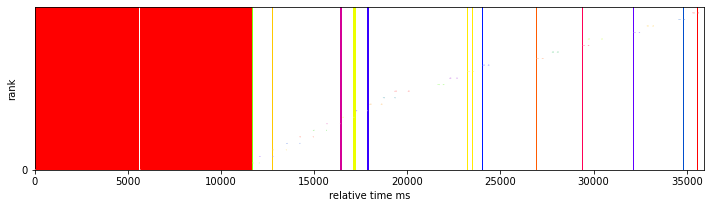

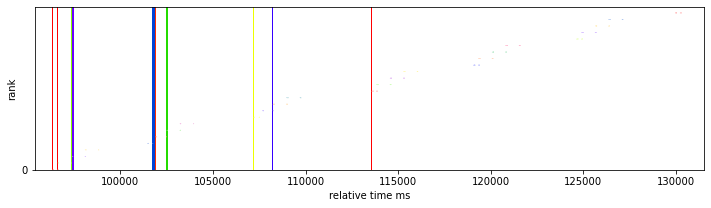

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.patheffects as PathEffects

cmap = cm.prism


rdata = (data - np.min(data))*1000


ranks = np.shape(rdata)[0]
epochs = np.shape(rdata)[1]
batches = np.shape(rdata)[2]
batches = min(25, batches) 

norm = Normalize(vmin=0, vmax=batches)

for e in range(epochs):
    fig, ax = plt.subplots(figsize=(12, 3))

    ax.set_ylim(0, ranks) # 0..ranks 

    ax.set_xlim(np.min(rdata[:, e, 0:batches])*0.99, np.max(rdata[:, e, 0:batches])*1.01)
    print(np.max(rdata[:, e, 0:batches]))

    ax.set_xlabel("relative time ms")

    ax.set_yticks(list(range(ranks)))
    ax.set_ylabel("rank")

    path_effects = [PathEffects.withStroke(linewidth=0.1, foreground='w')]

    for r in range(ranks):
        for i in range(batches):
            col = cmap(norm(i))
            ts = rdata[r, e, i]
            ax.broken_barh([(ts[0], ts[1]-ts[0]), (ts[2], ts[3]-ts[2])], (r, 1), facecolors=col)
    #         ax.annotate(f"+{i}", (ts[0], r + 0.25), fontsize=2)
    #         ax.annotate(f"-{i}", (ts[2], r + 0.75), fontsize=2)
            annot_y = r + i/batches
    #         ax.scatter([ts[0], ts[2]], [annot_y, annot_y], s=1)
            ax.text(ts[0], annot_y, f"+{i}", fontsize=1, ha='left', c=col, path_effects=path_effects)

            ax.text(ts[2], annot_y, f"-{i}", fontsize=1, ha='left', c=col, path_effects=path_effects)


    # plt.figure(figsize=(20,10))
    plt.savefig(f"1_{data_dir.split('/')[-1]}_{batch_size}_{e}.png", dpi=1024) 


In [21]:
# save data to csv
fname = f"1_{data_dir.split('/')[-1]}_{batch_size}.csv"
with open(fname, "w") as f:
    f.write("batch_size,epoch,rank,batch,fwd_start_ts, fwd_end_ts, bwd_start_ts, bwd_end_ts\n")
    shape = np.shape(data)
    for r in range(shape[0]):
        for e in range(shape[1]):
            for b in range(shape[2]):
                ts = data[r, e, b]
                f.write(f"{batch_size}, {e}, {r}, {b}, {ts[0]}, {ts[1]}, {ts[2]}, {ts[3]}\n")
print(f"{fname} complete!")                
        

dp_models.alexnet.gpus=4_straight_512.csv complete!
